# Imports

In [1]:
import sys

sys.path.append("../src")

In [2]:
import argparse
import glob
import json
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SimpleITK as sitk
import vtk
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from dtu_spine_config import DTUConfig

# Segmentation

In [3]:
def analyze_one_segmentation(segmentation_name):
    # L1 has label 20
    label_id = 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        return None

    segm_np = sitk.GetArrayFromImage(img)

    # Due to the coordinate conventions in SimpleITK and numpy we need to reorder the image
    # mosty usefull if you need coordinate conversions between the image and the numpy array
    segm_np = segm_np.transpose(2, 1, 0)

    binary_segmentation = segm_np == label_id
    if np.sum(binary_segmentation) == 0:
        print(f"Label {label_id} not found in {segmentation_name}")
        return None

    # Compute the volume of the segmentation
    volume_voxels = np.sum(binary_segmentation)
    # use spacing to compute volume in square millimeters
    volume_mm3 = volume_voxels * np.prod(img.GetSpacing())

    return volume_mm3

In [4]:
vol = analyze_one_segmentation(
    "/work3/rapa/challenge_data/train/crops/sample_0097_crop_label_sphere_outlier_water.nii.gz"
)

In [5]:
# segmentation_name =  "/work3/rapa/challenge_data/train/crops/sample_0098_crop_label_sphere_outlier_water.nii.gz"
# segmentation_name =  "/work3/rapa/challenge_data/train/crops/sample_0097_crop_label_sphere_outlier_water.nii.gz"
segmentation_name = (
    "/work3/rapa/challenge_data/train/crops/sample_0097_crop_label.nii.gz"
)

In [6]:
# L1 has label 20
label_id = 20

# Read the segmentation and turn into a numpy array
try:
    img = sitk.ReadImage(segmentation_name)
except RuntimeError as e:
    print(f"Got an exception {str(e)}")
    print(f"Error reading {segmentation_name}")
    raise

segm_np = sitk.GetArrayFromImage(img)

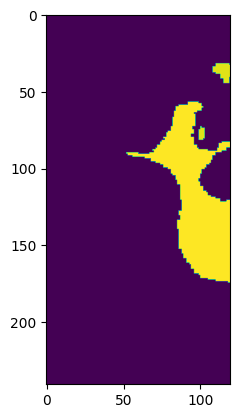

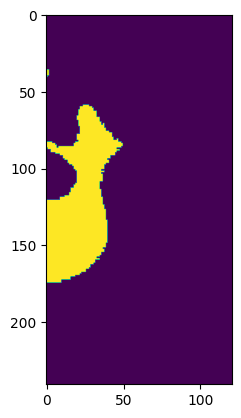

In [7]:
plt.imshow(segm_np[128, :, :120])
plt.show()
plt.imshow(segm_np[128, :, 120:])
plt.show()

In [8]:
left = segm_np[..., :120]
right = segm_np[..., 120:-1]

In [9]:
left.shape, right.shape

((241, 241, 120), (241, 241, 120))

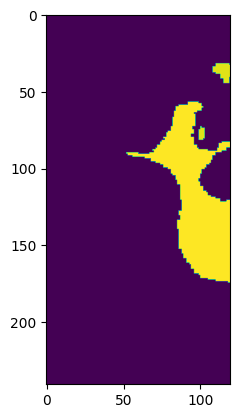

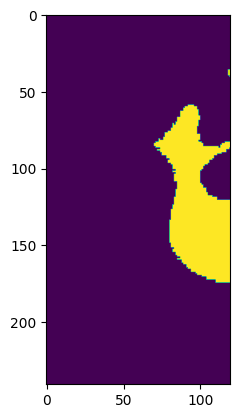

In [10]:
plt.imshow(left[128, ...])
plt.show()
plt.imshow(np.flip(right, 2)[128, ...])
plt.show()

In [11]:
np.abs(left - np.flip(right, 2)).mean()

1627.45305076818

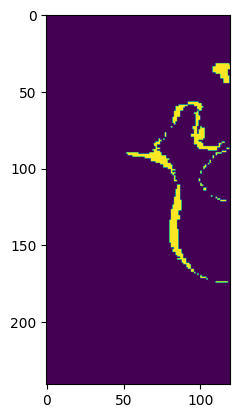

In [12]:
diff = left != np.flip(right, 2)
# diff[~(left | np.flip(right, 2)).astype(bool)] = 0
plt.imshow(diff[128, ...])

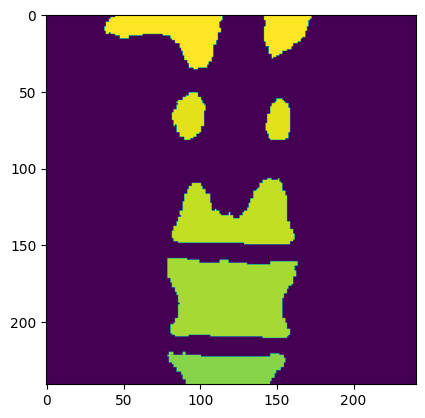

In [13]:
plt.imshow(segm_np[:, 120, :])

In [14]:
np.unique(segm_np)

array([ 0, 17, 18, 19, 20, 21, 22], dtype=uint16)

# Get training

In [15]:
training_id_list_file = "../challenge_results/custom_train_list_436.txt"
all_scan_ids = np.loadtxt(str(training_id_list_file), delimiter=",", dtype=str)
train_dir = "/work3/rapa/challenge_data/train"

In [16]:
def get_diff(arr):
    arr = arr == 20
    left = arr[..., :120]
    right = arr[..., 120:-1]
    # return (left != np.flip(right, 2)).sum()
    # n = left.sum() + right.sum()
    # return (left != np.flip(right, 2)).sum() / n
    intersection = left != np.flip(right, 2)
    union = left | np.flip(right, 2)
    # return intersection.sum() / union.sum()
    plt.imshow(intersection[120, ...])
    plt.show()
    plt.imshow(union[120, ...])
    plt.show()

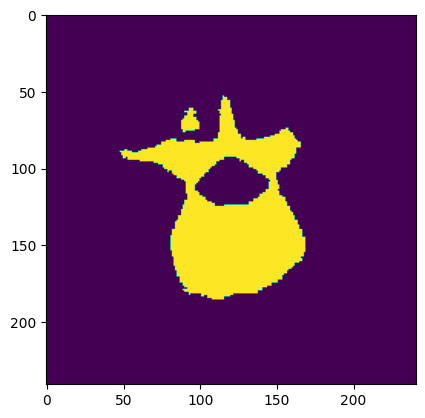

In [17]:
plt.imshow(segm_np[115, ...] == 20)

In [18]:
seg_where = np.where(segm_np == 20)
com = seg_where[1].mean(), seg_where[2].mean()
mask = seg_where[1] < 120
seg_where = [seg[mask] for seg in seg_where]
min_index = seg_where[1].argmin()
max_index = seg_where[1].argmax()

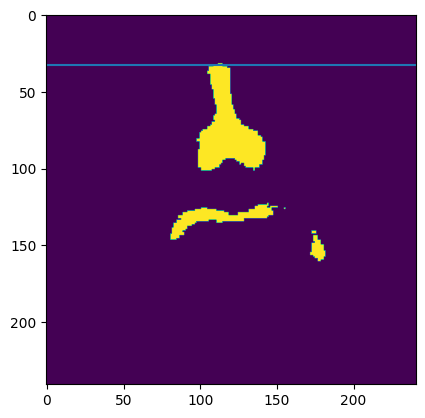

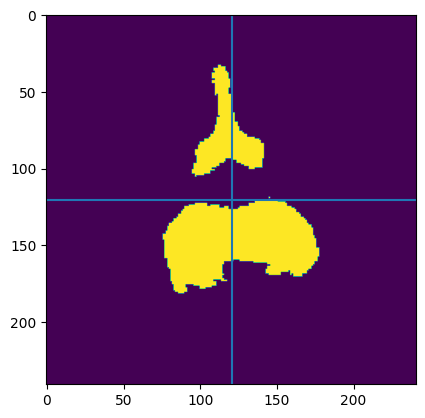

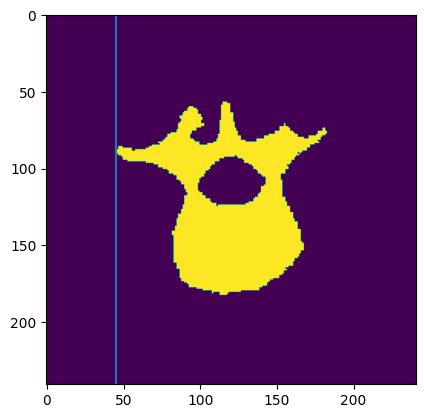

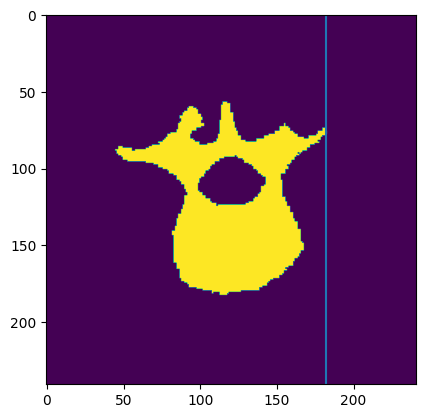

In [19]:
min_index = seg_where[1].argmin()
plt.imshow(segm_np[seg_where[0][min_index], ...] == 20)
plt.axhline(seg_where[1][min_index])
plt.show()

max_index = seg_where[1].argmax()
plt.imshow(segm_np[seg_where[0][max_index], ...] == 20)
# plt.axhline(seg_where[1][max_index])
plt.axhline(com[1])
plt.axvline(com[0])

plt.show()

min_index = seg_where[2].argmin()
plt.imshow(segm_np[seg_where[0][min_index], ...] == 20)
plt.axvline(seg_where[2][min_index])
plt.show()

max_index = seg_where[2].argmax()
plt.imshow(segm_np[seg_where[0][max_index], ...] == 20)
plt.axvline(seg_where[2][max_index])
plt.show()

# min_index = seg_where[2].argmin()
# max_index = seg_where[2].argmax()
# plt.axvline(seg_where[2][max_index])
# plt.axvline(seg_where[2][min_index])

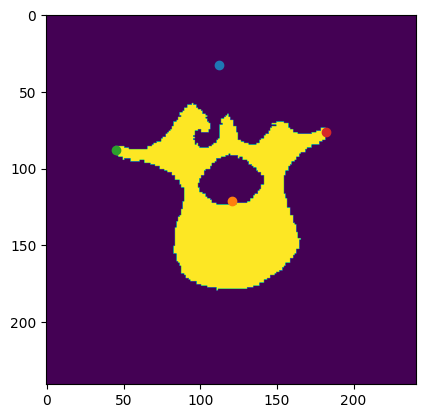

In [20]:
plt.imshow(segm_np[120, ...] == 20)
min_index = seg_where[1].argmin()
max_index = seg_where[1].argmax()
plt.scatter(seg_where[2][min_index], seg_where[1][min_index])
plt.scatter(com[1], com[0])

min_index = seg_where[2].argmin()
max_index = seg_where[2].argmax()
# plt.axvline(seg_where[2][max_index])
# plt.axvline(seg_where[2][min_index])
plt.scatter(seg_where[2][min_index], seg_where[1][min_index])
plt.scatter(seg_where[2][max_index], seg_where[1][max_index])

In [21]:
min_index = seg_where[1].argmin()
# max_index = seg_where[1].argmax()
vec0 = seg_where[2][min_index] - com[1], seg_where[1][min_index] - com[0]

min_index = seg_where[2].argmin()
max_index = seg_where[2].argmax()
vec1 = (
    seg_where[2][max_index] - seg_where[2][min_index],
    seg_where[1][max_index] - seg_where[1][min_index],
)
vec0, vec1

((-8.42765870152654, -88.96423751114129), (137, -12))

In [22]:
angle0 = np.arctan(vec0[1] / vec0[0]) - np.pi / 2
angle1 = np.arctan(vec1[1] / vec1[0])
print(angle0 / np.pi * 180)
print(angle1 / np.pi * 180)

-5.411529434249244
-5.005832552951089


In [23]:
from scipy.ndimage import rotate

In [24]:
segm_np_rot = (
    rotate(
        (segm_np == 20).astype(float),
        angle0 / np.pi * 180,
        axes=(1, 2),
        reshape=False,
        order=0,
    )
    > 0.5
)

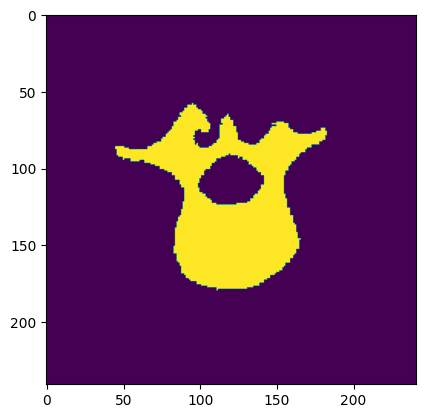

In [25]:
plt.imshow(segm_np[120, ...] == 20)
plt.show()
# plt.imshow(segm_np_rot[120, ...])
# plt.show()
# plt.imshow(align(segm_np)[120, ...])
# plt.show()

In [26]:
from scipy.ndimage import binary_dilation, binary_erosion

In [27]:
def align(segm_np):
    seg_where = np.where(segm_np == 20)
    segm_np = segm_np[
        seg_where[0].min() : seg_where[0].max(),
        seg_where[1].min() : seg_where[1].max(),
        seg_where[2].min() : seg_where[2].max(),
    ]
    # segm_np = segm_np[seg_where[0].min():seg_where[0].max(), ...]
    seg_where = np.where(segm_np == 20)
    com = seg_where[1].mean(), seg_where[2].mean()
    # mask = seg_where[1] < 120
    # seg_where = [seg[mask] for seg in seg_where]
    min_index = seg_where[1].argmin()
    vec0 = seg_where[2][min_index] - com[1], seg_where[1][min_index] - com[0]
    angle0 = np.arctan(vec0[1] / vec0[0]) - np.pi / 2

    segm_np_rot = (
        rotate(
            (segm_np == 20).astype(float),
            angle0 / np.pi * 180,
            axes=(1, 2),
            reshape=True,
            order=0,
        )
        > 0.5
    )
    return segm_np_rot


def get_diff(arr):
    # arr = arr == 20
    com_z = int(np.where(arr)[2].mean())

    overshoot = min(arr.shape[2] - 2 * com_z, 0)
    left = arr[..., abs(overshoot) : com_z]
    right = arr[..., com_z : min(arr.shape[2], 2 * com_z)]
    # return (left != np.flip(right, 2)).sum()
    # n = left.sum() + right.sum()
    # return (left != np.flip(right, 2)).sum() / n
    intersection = left != np.flip(right, 2)
    intersection = binary_erosion(intersection, iterations=1)
    # intersection = binary_dilation(intersection, iterations=1)
    union = left | np.flip(right, 2)
    return intersection.sum() / union.sum()
    # plt.imshow(intersection[arr.shape[0] // 2, ...])
    # plt.show()
    # plt.imshow(union[arr.shape[0] // 2, ...])
    # plt.show()

In [28]:
# get_diff(segm_np == 20)
# get_diff(align(segm_np))

In [29]:
diffs = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{train_dir}/crops/{id}_crop_label.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs.append(get_diff(align(segm_np)))

  0%|          | 0/436 [00:00<?, ?it/s]

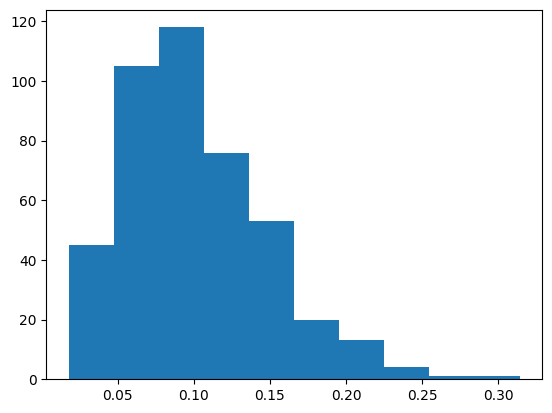

In [30]:
plt.hist(diffs);

In [31]:
diffs_warp = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{train_dir}/crops/{id}_crop_label_warp_outlier.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs_warp.append(get_diff(align(segm_np)))

  0%|          | 0/436 [00:00<?, ?it/s]

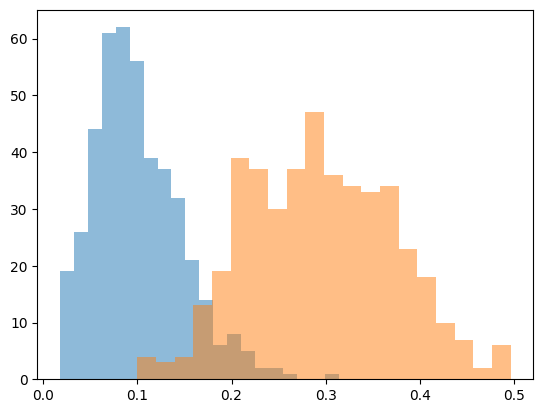

In [32]:
fig, ax = plt.subplots(1, 1, sharex=True)

ax.hist(diffs, alpha=0.5, bins=20)
ax.hist(diffs_warp, alpha=0.5, bins=20);

In [33]:
diffs_sphere = []
for id in tqdm(all_scan_ids):
    segmentation_name = f"{train_dir}/crops/{id}_crop_label_sphere_outlier_water.nii.gz"
    # L1 has label 20

    # Read the segmentation and turn into a numpy array
    try:
        img = sitk.ReadImage(segmentation_name)
    except RuntimeError as e:
        print(f"Got an exception {str(e)}")
        print(f"Error reading {segmentation_name}")
        raise

    segm_np = sitk.GetArrayFromImage(img)

    diffs_sphere.append(get_diff(align(segm_np)))

  0%|          | 0/436 [00:00<?, ?it/s]

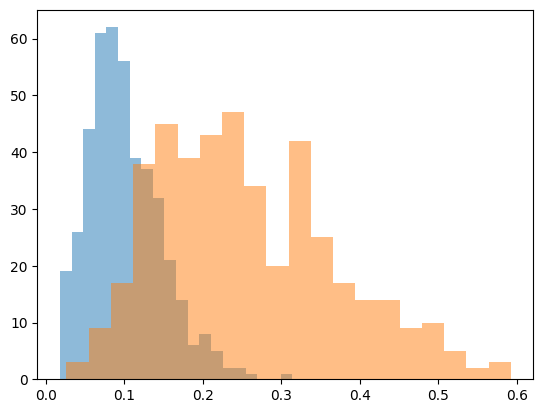

In [34]:
fig, ax = plt.subplots(1, 1, sharex=True)

ax.hist(diffs, alpha=0.5, bins=20)
ax.hist(diffs_sphere, alpha=0.5, bins=20);

In [35]:
diffs[0], diffs_sphere[0]

(0.07959342804017736, 0.4243014206066118)

# Method

In [38]:
threshold = np.quantile(diffs, 0.95)
threshold

0.19053592528785745

In [66]:
def align(segm_np):
    seg_where = np.where(segm_np == 20)
    segm_np = segm_np[
        seg_where[0].min() : seg_where[0].max(),
        seg_where[1].min() : seg_where[1].max(),
        seg_where[2].min() : seg_where[2].max(),
    ]

    seg_where = np.where(segm_np == 20)
    com = seg_where[1].mean(), seg_where[2].mean()

    min_index = seg_where[1].argmin()
    vec0 = seg_where[2][min_index] - com[1], seg_where[1][min_index] - com[0]
    angle0 = np.arctan(vec0[1] / vec0[0]) - np.pi / 2

    segm_np_rot = (
        rotate(
            (segm_np == 20).astype(float),
            angle0 / np.pi * 180,
            axes=(1, 2),
            reshape=True,
            order=0,
        )
        > 0.5
    )
    return segm_np_rot

def get_diff(arr):
    com_z = int(np.where(arr)[2].mean())

    overshoot = min(arr.shape[2] - 2 * com_z, 0)
    left = arr[..., abs(overshoot) : com_z]
    right = arr[..., com_z : min(arr.shape[2], 2 * com_z)]

    intersection = left != np.flip(right, 2)
    intersection = binary_erosion(intersection, iterations=1)
    union = left | np.flip(right, 2)
    return intersection.sum() / union.sum()

def detect_outlier_symmetry(settings, threshold=0.19):
    data_dir = settings["data_dir"]
    segmentation_dir = os.path.join(data_dir, "train/crops")
    test_list = settings["data_set"]

    result_dir = settings["result_dir"]
    validation_results_json = os.path.join(result_dir, "validation_results.json")
    test_id_list_file = os.path.join(result_dir, test_list)
    
    all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    outliers_pred = []
    outliers_gt = []
    for idx in tqdm(all_scan_ids):
        scan_id = idx[0].strip()
        outlier_type = idx[1].strip()
        
        # surf_name = os.path.join(surface_dir, f"{scan_id}_surface{outlier_type}.vtk")
        segmentation_name = f"{segmentation_dir}/{scan_id}_crop_label{outlier_type}.nii.gz"

        # Read the segmentation and turn into a numpy array
        try:
            img = sitk.ReadImage(segmentation_name)
        except RuntimeError as e:
            print(f"Got an exception {str(e)}")
            print(f"Error reading {segmentation_name}")
            raise
    
        volume_seg = sitk.GetArrayFromImage(img)

        left_right_diff = get_diff(align(volume_seg))
        outlier_pred = left_right_diff > threshold

        outliers_pred.append(outlier_pred)
        outliers_gt.append(outlier_type != "")

    # Create classification results
    validation_results = []
    for i, id in enumerate(all_scan_ids):
        scan_id = id[0].strip()
        # Remember to cast bools to int for json serialization
        validation_results.append(
            {
                "scan_id": scan_id,
                "outlier": int(outliers_pred[i]),
                # "outlier_probability": outlier_probs[i],
                # "outlier_threshold": normalized_threshold,
            }
        )

    # Write classification results to file
    with open(validation_results_json, "w") as json_file:
        json.dump(validation_results, json_file, indent=4)

def unpack_results(settings):
    data_dir = settings["data_dir"]
    test_list = settings["data_set"]

    result_dir = settings["result_dir"]
    validation_results_json = os.path.join(result_dir, "validation_results.json")

    test_id_list_file = os.path.join(result_dir, test_list)
    all_scan_ids = np.loadtxt(str(test_id_list_file), delimiter=",", dtype=str)
    print(f"Found {len(all_scan_ids)} test samples in {test_id_list_file}")
    if len(all_scan_ids) == 0:
        print(f"No samples found")
        return

    with open(validation_results_json, "r") as json_file:
        validation_results = json.load(json_file)
    
    outliers_pred = []
    outliers_gt = []
    for i, id in enumerate(all_scan_ids):
        scan_id = id[0].strip()
        outlier_type = id[1].strip()
        
        outlier_pred = validation_results[i]["outlier"]
        outlier_gt = outlier_type != ""

        outliers_pred.append(bool(outlier_pred))
        outliers_gt.append(outlier_gt)
    return np.array(outliers_pred, dtype=bool), np.array(outliers_gt, dtype=bool)

def get_metrics(outliers_pred, outliers_gt):
    n_samples = outliers_gt.size
    
    # Compute metrics
    tp = np.sum(outliers_gt & outliers_pred)
    tn = np.sum(~outliers_gt & ~outliers_pred)
    fp = np.sum(~outliers_gt & outliers_pred)
    fn = np.sum(outliers_gt & ~outliers_pred)
    print(
        f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn} N_pred: {outliers_pred.sum()} N_samples: {n_samples}"
    )
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / n_samples
    cohens_kappa = (
        2 * (tp * tn - fn * fp) / ((tp + fp) * (fp + tn) + (tp + fn) * (fn + tn))
    )
    print(
        f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, Accuracy: {accuracy:.2f}, "
        f"Cohens kappa: {cohens_kappa:.2f}"
    )

In [67]:
with open("../src/outlier-challenge-config.json", "r") as openfile:
    settings = json.load(openfile)

settings["data_set"] = "custom_validation_list_110.txt"
settings["result_dir"] = "../challenge_results"
settings

{'team_name': 'testtest',
 'method_description': 'testtesttest',
 'data_types': 'Mesh, segmentation, image or a hybrid',
 'data_dir': '/work3/rapa/challenge_data/',
 'result_dir': '../challenge_results',
 'challenge_server': 'http://fungi.compute.dtu.dk:8080',
 'data_set': 'custom_validation_list_110.txt'}

In [68]:
detect_outlier_symmetry(settings)

Found 220 test samples in ../challenge_results/custom_validation_list_110.txt


  0%|          | 0/220 [00:00<?, ?it/s]

In [69]:
outliers_pred, outliers_gt = unpack_results(settings)

Found 220 test samples in ../challenge_results/custom_validation_list_110.txt


In [70]:
get_metrics(outliers_pred, outliers_gt)

TP: 124, TN: 47, FP: 8, FN: 41 N_pred: 132 N_samples: 220
Precision: 0.94, Recall: 0.75, F1: 0.84, Accuracy: 0.78, Cohens kappa: 0.51


## Validation